# Importar Bibliotecas Necessárias

In [1]:
# Importar as bibliotecas

# -*- coding: utf-8 -*-

import numpy as np
from timeit import default_timer as timer
import random
import serial
import serial.tools.list_ports
import os
from math import sqrt
import argparse
import matplotlib as plt
import pandas as pd
import tensorflow as tf

from datetime import datetime
from scipy.fft import fft

# https://www.linkedin.com/pulse/lendo-arquivos-csv-com-pandas-rog%C3%A9rio-guimar%C3%A3es-de-campos-j%C3%BAnior/
# https://stackabuse.com/python-list-files-in-a-directory/

C:\Users\ander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# Rede LSTM

In [2]:
# Carregar dados MPL para modelo RNN

# Definição do paciente e os diretórios
nome = "Anderson_CH1_MSE"

# Caminho dos dados
filename = f"Dataset\\{nome}\\dados_classificacao.csv"
filename_limiar = f"Dataset\\{nome}\\limiar.txt"
filename_movimentos = f"Dataset\\{nome}\\movimentos_classificacao.csv"


# Extração de características do sinal (Input Layer)

In [3]:
# Transforma de str para float

def str2float(Part):
    for i in range(0, len(Part)):
        Part[i] = Part[i].split(';')
        for j in range(0, len(Part[i])):
            Part[i][j] = float(Part[i][j].replace(',', '.'))

    return Part

In [4]:
# Calcula: RMS 

def f_rms(dado, segments):
    Vrms = []
    
    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    for s in range(0, segments): 
        soma = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2):
            soma = soma + (dado[sample] ** 2) 

        Vrms.append(sqrt(soma/segment))
        aux = aux_2 - 1

    return Vrms

In [5]:
# Detecta o impulso baseado no ruído em repouso do músculo
def delta_dirac(data_full, filename_limiar, N, janela):
    # Valor obtido empiricamente utilizando o repouso
    with open(filename_limiar, 'r') as l:
        limiar = l.read()
    
    limiar = float(limiar)
    segments = 1
    
    # Compara se algum dos valores é maior que o limiar, caso sim efetua o RMS
    # dos próximos 40 pontos (baseado em Rodrigo Ortolan)
    # Se o RMS desses 40 pontos for maior que o limiar considera este o inicio da contração 
    # E retorna 400 pontos referentes aos 200ms do começo do sinal
    for row in range(0, len(data_full)):
        if data_full[row] > limiar:
            rms = f_rms(data_full[row:(row + janela)], segments)
            if (rms[0]) > limiar:
                print (row)
                data_part = data_full[row:(row + N)]
                
                return data_part

In [6]:
# Calcula: Comprimento do traço do sinal

def waveform_length(dado, segments):
    # segment[sample] = Xk
    # segment[sample-1] = Xk-1
    
    l0_list = []
    
    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    for s in range(0, segments):
        l0 = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2):
            l0 = l0 + abs(dado[sample] - dado[sample-1])
        
        l0_list.append(l0)
        aux = aux_2
        
    # print (f"l0: {l0_list}")
    return l0_list

In [7]:
# Calcula: Média do Valor Absoluta

# Recebe uma amostra com 400 pontos e faz a media absoluta baseada na quantidade de segmentos
def mean_absolute_value(dado, segments):
    MAV = []
    
    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    
    for s in range(0, segments): 
        soma = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2):
                soma = soma + abs(float(dado[sample]))
    
        MAV.append(soma/segment)
        aux = aux_2 - 1
        
    # print (f"MAV: {MAV}")
    return MAV

In [8]:
# Calcula: Zero Crossing (ZC)

def zero_crossing(dado, segments): 
    ZC = []

    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    # X0 = Xk
    # X1 = Xk+1
    
    for s in range(0, segments): 
        count = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2-1):
            X0 = dado[sample]
            X1 = dado[sample + 1]
            # abs(Xk - Xk-1) >= 10mV
            # limiar (threshhold) = 10mV. Noise INA332 = 7uVp-p. Para ter contagem de ZC falsos
            if (((X0 > 0 and X1 < 0) or (X0 < 0 and X1 > 0)) and (abs(X0 - X1) >= 0.01)):
                count += 1
                # print (f"Diferença para ZC: {abs(X0 - X1)}")
        
        ZC.append(count)
        aux = aux_2 - 1
    
    # print (f"ZC: {ZC}")    
    return ZC
    
    

In [9]:
# Calcula: A mudança de sinais

def slope_sign_changes(dado, segments):
    SSC = []
    
    # X0 = Xk-1
    # X1 = Xk
    # X2 = Xk+1
    
    segment = int(len(dado)/segments)
    aux = 1
    aux_2 = segment
    
    for s in range(0, segments): 
        count = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2 - 1):
            X0 = dado[sample - 1]
            X1 = dado[sample]
            X2 = dado[sample + 1]
            if (((X1 > X0  and X1 > X2) or (X1 < X0 and X1 < X2)) and ((abs(X1 - X2) >= 0.01) or (abs(X1 - X0) >= 0.01))):
                count += 1
                
        SSC.append(count)
        aux = aux_2 - 1
    
    # print (f"SSC: {SSC}")
    return SSC

In [10]:
# Calcula: Ângulo de inclinação da média do valor absoluto

def mean_absolute_value_slope(dado, segments):
    # MAV = Xi
    # MAV1 = Xi+1
    
    MAVSLP = []
    MAV = mean_absolute_value(dado, segments)
    
    for s in range(0, (segments-1)):
        MAVSLP.append(abs(MAV[s+1] - MAV[s])) 
    
    MAVSLP.append(0.0)
    
    # print (f"MAVSLP{MAVSLP}")        
    return MAVSLP

In [14]:
lines = []
y = []
qty_lines = 40

with open(filename, 'r') as f:
    for i in range(0, qty_lines):
        lines.append(f.readline())
        
with open(filename_movimentos, 'r') as f:
    for i in range(0, qty_lines):
        read_data = f.readline()
        read_data = list(read_data.split(';'))
        for j in range(0, len(read_data)):
            read_data[j] = int(read_data[j])
        y.append(read_data)

lines = str2float(lines)

#display(lines[0])

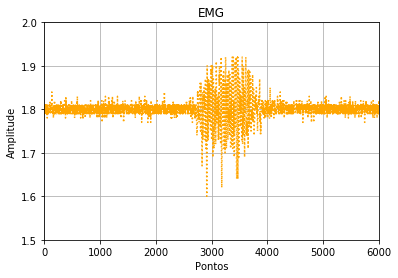

In [15]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(range(len(lines[0])))

plt.plot( x, lines[15], 'k:', color='orange') # linha pontilha orange

plt.axis([0, 6000, 1.5, 2])
plt.title("EMG")

plt.grid(True)
plt.xlabel("Pontos")
plt.ylabel("Amplitude")
plt.show()

In [16]:
# Definição de parâmetros para obtenção dos 200ms
N = 400
janela = 10

Part = []
i = 0

for line in lines:
    print (i+1)
    det = delta_dirac(line, filename_limiar, N, janela) 
    if (det != None):
        Part.append(det)
    else:
        y[i] = -1
    i += 1

# display(len(y))

while (-1 in y):
    y.remove(-1)

1
2792
2
3193
3
3017
4
3119
5
2681
6
3060
7
2905
8
2863
9
2830
10
2911
11
2957
12
2815
13
2781
14
3053
15
2892
16
2789
17
2830
18
2928
19
2878
20
2942
21
2868
22
2680
23
2647
24
2485
25
2963
26
3155
27
2846
28
2710
29
3826
30
3110
31
3383
32
3141
33
3460
34
3071
35
3378
36
2649
37
4138
38
3436
39
3125
40
3155


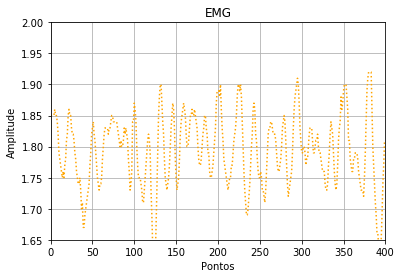

In [17]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(range(len(Part[0])))

plt.plot( x, Part[15], 'k:', color='orange') # linha pontilha orange

plt.axis([0, 400, 1.65, 2])
plt.title("EMG")

plt.grid(True)
plt.xlabel("Pontos")
plt.ylabel("Amplitude")
plt.show()

In [19]:
# Extrai os parâmetros necessários de uma segunda forma

# Adendo: Basicamente será testada a rede de Hudgins, mas diferente do artigo original será usada uma rede melhorada da RNN,
# que neste caso é a LSTM

# Criação do Array para LSTM
segments = 5 # Assim como Hudgins é possível modificar a quantidade de segmentos e ver o quanto melhora ou piora a acurácia obtida

X = np.ones((len(Part), 5, 6))

# Extrair características
for idx,p in enumerate(Part):
    X[idx,:,0] = mean_absolute_value(p, segments)
    X[idx,:,1] = waveform_length(p, segments)
    X[idx,:,2] = f_rms(p, segments)
    X[idx,:,3] = mean_absolute_value_slope(p, segments)
    X[idx,:,4] = zero_crossing(p, segments)
    X[idx,:,5] = slope_sign_changes(p, segments)

# Reshape deve ser: (quantidade de amostras, 3)
y = np.array(y)

display(X[0:2,:,:])
display(X[21:22,:,:])
display(y.shape)

array([[[1.79950000e+00, 7.30000000e-01, 1.79975623e+00, 1.68750000e-02,
         0.00000000e+00, 1.30000000e+01],
        [1.81637500e+00, 5.70000000e-01, 1.80543450e+00, 1.40000000e-02,
         0.00000000e+00, 3.00000000e+00],
        [1.80237500e+00, 1.30000000e+00, 1.79239539e+00, 2.83750000e-02,
         0.00000000e+00, 5.00000000e+00],
        [1.83075000e+00, 1.07000000e+00, 1.81991003e+00, 9.87500000e-03,
         0.00000000e+00, 8.00000000e+00],
        [1.82087500e+00, 1.45000000e+00, 1.81091862e+00, 0.00000000e+00,
         0.00000000e+00, 1.00000000e+01]],

       [[1.80850000e+00, 1.11000000e+00, 1.80918974e+00, 1.30000000e-02,
         0.00000000e+00, 6.00000000e+00],
        [1.82150000e+00, 9.50000000e-01, 1.81084580e+00, 2.87500000e-03,
         0.00000000e+00, 4.00000000e+00],
        [1.81862500e+00, 1.71000000e+00, 1.80872573e+00, 1.01250000e-02,
         0.00000000e+00, 6.00000000e+00],
        [1.82875000e+00, 1.04000000e+00, 1.81797277e+00, 6.87500000e-03,
     

array([[[1.81112500e+00, 1.11000000e+00, 1.81217514e+00, 5.62500000e-03,
         0.00000000e+00, 4.00000000e+00],
        [1.81675000e+00, 1.59000000e+00, 1.80690550e+00, 4.37500000e-03,
         0.00000000e+00, 9.00000000e+00],
        [1.82112500e+00, 1.43000000e+00, 1.81099662e+00, 6.00000000e-03,
         0.00000000e+00, 5.00000000e+00],
        [1.81512500e+00, 1.22000000e+00, 1.80484452e+00, 2.22044605e-16,
         0.00000000e+00, 9.00000000e+00],
        [1.81512500e+00, 1.17000000e+00, 1.80436658e+00, 0.00000000e+00,
         0.00000000e+00, 9.00000000e+00]]])

(40, 2)

In [25]:
# split into train and test sets
# split into input and outputs
train_X = X[0:31, :, :]
train_y = y[0:31, :]
test_X = X[32:40, :, :]
test_y = y[32:40, :]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(31, 5, 6) (31, 2) (8, 5, 6) (8, 2)


Train on 31 samples, validate on 8 samples
Epoch 1/250
31/31 [==============================] - 3s 95ms/sample - loss: 0.7304 - acc: 0.4677 - val_loss: 0.7638 - val_acc: 0.4375
Epoch 2/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.7021 - acc: 0.5000 - val_loss: 0.7742 - val_acc: 0.3125
Epoch 3/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6918 - acc: 0.5161 - val_loss: 0.7791 - val_acc: 0.2500
Epoch 4/250
31/31 [==============================] - 0s 3ms/sample - loss: 0.6854 - acc: 0.5000 - val_loss: 0.7825 - val_acc: 0.1875
Epoch 5/250
31/31 [==============================] - 0s 3ms/sample - loss: 0.6813 - acc: 0.4839 - val_loss: 0.7853 - val_acc: 0.1875
Epoch 6/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6786 - acc: 0.5323 - val_loss: 0.7878 - val_acc: 0.1250
Epoch 7/250
31/31 [==============================] - 0s 3ms/sample - loss: 0.6767 - acc: 0.5806 - val_loss: 0.7900 - val_acc: 0.1250
Epoch 8/250
31/31 [======

31/31 [==============================] - 0s 2ms/sample - loss: 0.6475 - acc: 0.6613 - val_loss: 0.7907 - val_acc: 0.1250
Epoch 61/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6472 - acc: 0.6613 - val_loss: 0.7901 - val_acc: 0.1250
Epoch 62/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6468 - acc: 0.6452 - val_loss: 0.7894 - val_acc: 0.1875
Epoch 63/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6465 - acc: 0.6452 - val_loss: 0.7888 - val_acc: 0.1875
Epoch 64/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6461 - acc: 0.6452 - val_loss: 0.7881 - val_acc: 0.1875
Epoch 65/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6458 - acc: 0.6613 - val_loss: 0.7874 - val_acc: 0.1875
Epoch 66/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6454 - acc: 0.6613 - val_loss: 0.7867 - val_acc: 0.2500
Epoch 67/250
31/31 [==============================] - 0s 2ms/sample - loss:

31/31 [==============================] - 0s 2ms/sample - loss: 0.6120 - acc: 0.7581 - val_loss: 0.7427 - val_acc: 0.5000
Epoch 122/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6109 - acc: 0.7581 - val_loss: 0.7417 - val_acc: 0.5000
Epoch 123/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6097 - acc: 0.7419 - val_loss: 0.7406 - val_acc: 0.5000
Epoch 124/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6085 - acc: 0.7581 - val_loss: 0.7396 - val_acc: 0.5000
Epoch 125/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6072 - acc: 0.7742 - val_loss: 0.7386 - val_acc: 0.5000
Epoch 126/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6059 - acc: 0.7742 - val_loss: 0.7377 - val_acc: 0.5000
Epoch 127/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.6045 - acc: 0.7742 - val_loss: 0.7368 - val_acc: 0.5000
Epoch 128/250
31/31 [==============================] - 0s 2ms/sample 

Epoch 182/250
31/31 [==============================] - 0s 3ms/sample - loss: 0.4944 - acc: 0.8065 - val_loss: 0.7549 - val_acc: 0.5000
Epoch 183/250
31/31 [==============================] - 0s 3ms/sample - loss: 0.4920 - acc: 0.8065 - val_loss: 0.7557 - val_acc: 0.5000
Epoch 184/250
31/31 [==============================] - 0s 3ms/sample - loss: 0.4895 - acc: 0.8065 - val_loss: 0.7559 - val_acc: 0.5000
Epoch 185/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.4872 - acc: 0.8065 - val_loss: 0.7568 - val_acc: 0.5000
Epoch 186/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.4847 - acc: 0.8226 - val_loss: 0.7578 - val_acc: 0.5000
Epoch 187/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.4822 - acc: 0.8226 - val_loss: 0.7585 - val_acc: 0.5000
Epoch 188/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.4796 - acc: 0.8226 - val_loss: 0.7588 - val_acc: 0.5000
Epoch 189/250
31/31 [==============================] - 

31/31 [==============================] - 0s 2ms/sample - loss: 0.3386 - acc: 0.8710 - val_loss: 0.9566 - val_acc: 0.5000
Epoch 243/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.3360 - acc: 0.8710 - val_loss: 0.9631 - val_acc: 0.5000
Epoch 244/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.3334 - acc: 0.8710 - val_loss: 0.9700 - val_acc: 0.5000
Epoch 245/250
31/31 [==============================] - 0s 3ms/sample - loss: 0.3307 - acc: 0.8710 - val_loss: 0.9773 - val_acc: 0.5000
Epoch 246/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.3281 - acc: 0.8710 - val_loss: 0.9846 - val_acc: 0.5000
Epoch 247/250
31/31 [==============================] - 0s 3ms/sample - loss: 0.3253 - acc: 0.8710 - val_loss: 0.9910 - val_acc: 0.5000
Epoch 248/250
31/31 [==============================] - 0s 2ms/sample - loss: 0.3228 - acc: 0.8710 - val_loss: 0.9983 - val_acc: 0.5000
Epoch 249/250
31/31 [==============================] - 0s 2ms/sample 

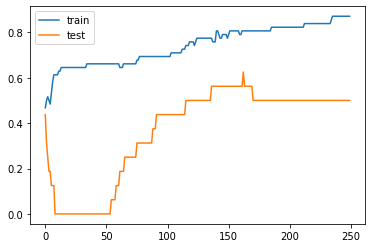

In [41]:
# Criar a rede LSTM
# Importar bibliotecas para criação do modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras import Input

# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=250, batch_size=5, validation_data=(test_X, test_y), shuffle=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 31 samples, validate on 8 samples
Epoch 1/500
31/31 - 3s - loss: 0.7056 - acc: 0.4839 - val_loss: 0.8325 - val_acc: 0.0000e+00
Epoch 2/500
31/31 - 0s - loss: 0.6701 - acc: 0.6452 - val_loss: 1.0098 - val_acc: 0.0000e+00
Epoch 3/500
31/31 - 0s - loss: 0.6605 - acc: 0.6452 - val_loss: 1.0590 - val_acc: 0.0000e+00
Epoch 4/500
31/31 - 0s - loss: 0.6543 - acc: 0.6452 - val_loss: 1.0971 - val_acc: 0.0000e+00
Epoch 5/500
31/31 - 0s - loss: 0.6516 - acc: 0.6452 - val_loss: 1.1181 - val_acc: 0.0000e+00
Epoch 6/500
31/31 - 0s - loss: 0.6503 - acc: 0.6452 - val_loss: 1.1338 - val_acc: 0.0000e+00
Epoch 7/500
31/31 - 0s - loss: 0.6542 - acc: 0.6452 - val_loss: 1.1563 - val_acc: 0.0000e+00
Epoch 8/500
31/31 - 0s - loss: 0.6528 - acc: 0.6452 - val_loss: 1.0377 - val_acc: 0.0000e+00
Epoch 9/500
31/31 - 0s - loss: 0.6420 - acc: 0.6452 - val_loss: 0.9456 - val_acc: 0.0000e+00
Epoch 10/500
31/31 - 0s - loss: 0.6427 - acc: 0.6452 - val_loss: 0.8757 - val_acc: 0.0000e+00
Epoch 11/500
31/31 - 0s - 

Epoch 90/500
31/31 - 0s - loss: 0.5219 - acc: 0.7742 - val_loss: 0.9491 - val_acc: 0.3750
Epoch 91/500
31/31 - 0s - loss: 0.5124 - acc: 0.8065 - val_loss: 0.8687 - val_acc: 0.5000
Epoch 92/500
31/31 - 0s - loss: 0.5164 - acc: 0.7742 - val_loss: 0.8136 - val_acc: 0.5000
Epoch 93/500
31/31 - 0s - loss: 0.5174 - acc: 0.7742 - val_loss: 0.9083 - val_acc: 0.5000
Epoch 94/500
31/31 - 0s - loss: 0.5039 - acc: 0.7742 - val_loss: 0.8344 - val_acc: 0.5000
Epoch 95/500
31/31 - 0s - loss: 0.5045 - acc: 0.7742 - val_loss: 0.8392 - val_acc: 0.5000
Epoch 96/500
31/31 - 0s - loss: 0.5008 - acc: 0.7742 - val_loss: 0.8752 - val_acc: 0.5000
Epoch 97/500
31/31 - 0s - loss: 0.4973 - acc: 0.7742 - val_loss: 0.9454 - val_acc: 0.5000
Epoch 98/500
31/31 - 0s - loss: 0.5002 - acc: 0.7742 - val_loss: 0.9698 - val_acc: 0.5000
Epoch 99/500
31/31 - 0s - loss: 0.5047 - acc: 0.7742 - val_loss: 0.8156 - val_acc: 0.5000
Epoch 100/500
31/31 - 0s - loss: 0.4902 - acc: 0.7742 - val_loss: 0.8600 - val_acc: 0.5000
Epoch 101

31/31 - 0s - loss: 0.3370 - acc: 0.9032 - val_loss: 1.1484 - val_acc: 0.3750
Epoch 181/500
31/31 - 0s - loss: 0.3418 - acc: 0.9032 - val_loss: 1.0973 - val_acc: 0.3750
Epoch 182/500
31/31 - 0s - loss: 0.3466 - acc: 0.8710 - val_loss: 1.1984 - val_acc: 0.3750
Epoch 183/500
31/31 - 0s - loss: 0.3443 - acc: 0.9032 - val_loss: 1.0174 - val_acc: 0.3750
Epoch 184/500
31/31 - 0s - loss: 0.3244 - acc: 0.9032 - val_loss: 1.0866 - val_acc: 0.3750
Epoch 185/500
31/31 - 0s - loss: 0.3283 - acc: 0.9032 - val_loss: 1.0880 - val_acc: 0.3750
Epoch 186/500
31/31 - 0s - loss: 0.3440 - acc: 0.9032 - val_loss: 0.9115 - val_acc: 0.5000
Epoch 187/500
31/31 - 0s - loss: 0.3284 - acc: 0.9355 - val_loss: 1.0743 - val_acc: 0.3750
Epoch 188/500
31/31 - 0s - loss: 0.3257 - acc: 0.9032 - val_loss: 1.1884 - val_acc: 0.3750
Epoch 189/500
31/31 - 0s - loss: 0.3219 - acc: 0.9032 - val_loss: 1.1491 - val_acc: 0.3750
Epoch 190/500
31/31 - 0s - loss: 0.3222 - acc: 0.8710 - val_loss: 1.2465 - val_acc: 0.3750
Epoch 191/500

Epoch 271/500
31/31 - 0s - loss: 0.1515 - acc: 0.9677 - val_loss: 1.3132 - val_acc: 0.5000
Epoch 272/500
31/31 - 0s - loss: 0.1502 - acc: 0.9677 - val_loss: 1.4156 - val_acc: 0.3750
Epoch 273/500
31/31 - 0s - loss: 0.1504 - acc: 0.9677 - val_loss: 1.4408 - val_acc: 0.3750
Epoch 274/500
31/31 - 0s - loss: 0.1883 - acc: 0.9677 - val_loss: 1.1502 - val_acc: 0.3750
Epoch 275/500
31/31 - 0s - loss: 0.1721 - acc: 0.9677 - val_loss: 1.4468 - val_acc: 0.3750
Epoch 276/500
31/31 - 0s - loss: 0.1525 - acc: 0.9677 - val_loss: 1.6253 - val_acc: 0.3750
Epoch 277/500
31/31 - 0s - loss: 0.1443 - acc: 0.9677 - val_loss: 1.4503 - val_acc: 0.3750
Epoch 278/500
31/31 - 0s - loss: 0.1570 - acc: 0.9677 - val_loss: 1.5603 - val_acc: 0.3750
Epoch 279/500
31/31 - 0s - loss: 0.1330 - acc: 0.9677 - val_loss: 1.3405 - val_acc: 0.3750
Epoch 280/500
31/31 - 0s - loss: 0.1403 - acc: 0.9677 - val_loss: 1.2972 - val_acc: 0.5000
Epoch 281/500
31/31 - 0s - loss: 0.1415 - acc: 0.9677 - val_loss: 1.3007 - val_acc: 0.3750

Epoch 362/500
31/31 - 0s - loss: 0.0410 - acc: 1.0000 - val_loss: 1.7088 - val_acc: 0.5000
Epoch 363/500
31/31 - 0s - loss: 0.0405 - acc: 1.0000 - val_loss: 1.7571 - val_acc: 0.5000
Epoch 364/500
31/31 - 0s - loss: 0.0398 - acc: 1.0000 - val_loss: 1.8174 - val_acc: 0.5000
Epoch 365/500
31/31 - 0s - loss: 0.0422 - acc: 1.0000 - val_loss: 1.7112 - val_acc: 0.5000
Epoch 366/500
31/31 - 0s - loss: 0.0398 - acc: 1.0000 - val_loss: 1.7402 - val_acc: 0.5000
Epoch 367/500
31/31 - 0s - loss: 0.0375 - acc: 1.0000 - val_loss: 1.8441 - val_acc: 0.5000
Epoch 368/500
31/31 - 0s - loss: 0.0477 - acc: 1.0000 - val_loss: 2.0522 - val_acc: 0.5000
Epoch 369/500
31/31 - 0s - loss: 0.0600 - acc: 1.0000 - val_loss: 1.6254 - val_acc: 0.5000
Epoch 370/500
31/31 - 0s - loss: 0.0420 - acc: 1.0000 - val_loss: 1.6051 - val_acc: 0.5000
Epoch 371/500
31/31 - 0s - loss: 0.0385 - acc: 1.0000 - val_loss: 1.6948 - val_acc: 0.5000
Epoch 372/500
31/31 - 0s - loss: 0.0364 - acc: 1.0000 - val_loss: 1.8031 - val_acc: 0.5000

31/31 - 0s - loss: 0.0199 - acc: 1.0000 - val_loss: 1.7665 - val_acc: 0.6250
Epoch 453/500
31/31 - 0s - loss: 0.0119 - acc: 1.0000 - val_loss: 2.1298 - val_acc: 0.5000
Epoch 454/500
31/31 - 0s - loss: 0.0238 - acc: 1.0000 - val_loss: 2.3137 - val_acc: 0.5000
Epoch 455/500
31/31 - 0s - loss: 0.0159 - acc: 1.0000 - val_loss: 1.9203 - val_acc: 0.5000
Epoch 456/500
31/31 - 0s - loss: 0.0134 - acc: 1.0000 - val_loss: 1.8491 - val_acc: 0.5000
Epoch 457/500
31/31 - 0s - loss: 0.0134 - acc: 1.0000 - val_loss: 1.9687 - val_acc: 0.5000
Epoch 458/500
31/31 - 0s - loss: 0.0120 - acc: 1.0000 - val_loss: 2.1409 - val_acc: 0.5000
Epoch 459/500
31/31 - 0s - loss: 0.0113 - acc: 1.0000 - val_loss: 2.0539 - val_acc: 0.5000
Epoch 460/500
31/31 - 0s - loss: 0.0103 - acc: 1.0000 - val_loss: 1.9947 - val_acc: 0.5000
Epoch 461/500
31/31 - 0s - loss: 0.0105 - acc: 1.0000 - val_loss: 1.9257 - val_acc: 0.5000
Epoch 462/500
31/31 - 0s - loss: 0.0103 - acc: 1.0000 - val_loss: 2.0282 - val_acc: 0.5000
Epoch 463/500

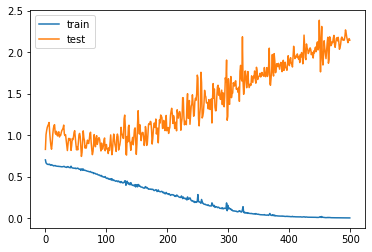

In [38]:
# Criar a rede GRU

# design network
model = Sequential()
model.add(GRU(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [10]:
# Verificar acurácia e perda